# Time Series with XGBoost - COVID

## Import Packages

In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import pickle
from datetime import timedelta, date
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Import Data

In [95]:
with open('covid_data.p', 'rb') as f:
    data = pickle.load(f)

In [96]:
# Basic data cleanup
data = data[data.fips_code == '36047'] #36047
data = data.set_index('date')

data = data[['deaths_cdc','confirmed_cdc']]

max_date = data.index[-1].date().strftime('%Y-%m-%d')

data['daily_deaths'] = data.deaths_cdc.diff().rolling(window=28).mean()
#data['daily_deaths'] = data.deaths_cdc.rolling(window=7).mean()
data['daily_deaths_off1'] =  data.daily_deaths.shift(periods=1)
data['daily_deaths_off2'] =  data.daily_deaths.shift(periods=2)
data['daily_deaths_off3'] =  data.daily_deaths.shift(periods=3)
data['daily_deaths_off4'] =  data.daily_deaths.shift(periods=4)

#data['daily_cases'] = data.confirmed_cdc.diff().rolling(window=28).mean()
#data['daily_cases_off1'] =  data.daily_cases.shift(periods=1)
#data['daily_cases_off2'] =  data.daily_cases.shift(periods=2)
#data['daily_cases_off3'] =  data.daily_cases.shift(periods=3)
#data['daily_cases_off4'] =  data.daily_cases.shift(periods=4)

data['pred_deaths'] = data.daily_deaths

data.sort_index(inplace=True)
data = data.dropna()

# For debugging
df = pd.DataFrame(data)

data.tail()

,deaths_cdc,confirmed_cdc,daily_deaths,daily_deaths_off1,daily_deaths_off2,daily_deaths_off3,daily_deaths_off4,pred_deaths
date,,,,,,,,
2021-01-11,7914.0,137959.0,12.285714,11.857143,11.535714,11.107143,10.357143,12.285714
2021-01-12,7923.0,139672.0,12.428571,12.285714,11.857143,11.535714,11.107143,12.428571
2021-01-13,7941.0,141535.0,12.785714,12.428571,12.285714,11.857143,11.535714,12.785714
2021-01-14,7970.0,143078.0,13.678571,12.785714,12.428571,12.285714,11.857143,13.678571
2021-01-15,7994.0,145424.0,14.178571,13.678571,12.785714,12.428571,12.285714,14.178571


## Split the data

In [97]:
def split_data(data, split_date):
    return data[data.index <= split_date].copy(), \
           data[data.index >  split_date].copy()

In [98]:
#train, test = split_data(data, (data.index[-1].date() - timedelta(days=90)).strftime('%Y-%m-%d'))
train, test = split_data(data, "2020-10-01")

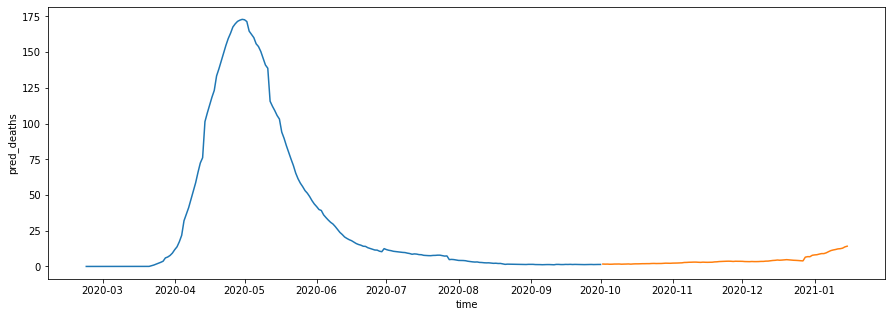

In [99]:
# Plot the train & test data
plt.figure(figsize=(15,5))
plt.xlabel('time')
plt.ylabel('pred_deaths')
plt.plot(train.index,train["pred_deaths"])
plt.plot(test.index,test["pred_deaths"])
plt.show()

## Feature Engineering

In [100]:
def create_features(df):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    #df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    # Time from 1/1/2020
    df["origin"] = pd.to_datetime(date(2020,1,1))
    df["t-t0"] = (df["date"] - df["origin"]).dt.days
    
    X = df[[
            't-t0',
            'dayofweek',
            #'quarter','month','year',
            #'dayofyear',
            #'dayofmonth','weekofyear',
            #'3_day_ave', '5_day_ave', #'7_day_ave','14_day_ave',
            #'deaths_cdc', 
            #'confirmed_cdc',
            #'3_day_case_ave', '5_day_case_ave','7_day_case_ave','14_day_case_ave',
            #'daily_deaths'
            'daily_deaths_off1', 'daily_deaths_off2', 'daily_deaths_off3', 'daily_deaths_off4',
            #'daily_cases_off1', #'daily_cases_off2', 'daily_cases_off3','daily_cases_off4',
            
           ]]
    return X

In [101]:
X_train, y_train = create_features(train), train['pred_deaths']
X_test, y_test   = create_features(test), test['pred_deaths'] 

X_train.shape, y_train.shape

/home/james/.conda/envs/moby/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  if sys.path[0] == '':


((222, 6), (222,))

## Train the Model

In [102]:
reg = xgb.XGBRegressor(
    n_estimators=10000,
    learning_rate=0.05,
    max_depth=6
)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
        verbose=10)

[0]	validation_0-rmse:57.32583	validation_1-rmse:4.63606
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:35.51092	validation_1-rmse:3.26744
[20]	validation_0-rmse:22.10776	validation_1-rmse:2.44668
[30]	validation_0-rmse:13.84007	validation_1-rmse:2.02601
[40]	validation_0-rmse:8.73300	validation_1-rmse:1.76060
[50]	validation_0-rmse:5.55542	validation_1-rmse:1.65749
[60]	validation_0-rmse:3.58699	validation_1-rmse:1.59856
[70]	validation_0-rmse:2.35106	validation_1-rmse:1.54862
[80]	validation_0-rmse:1.57512	validation_1-rmse:1.51612
[90]	validation_0-rmse:1.09037	validation_1-rmse:1.49547
[100]	validation_0-rmse:0.77163	validation_1-rmse:1.47539
[110]	validation_0-rmse:0.56193	validation_1-rmse:1.46379
[120]	validation_0-rmse:0.41841	validation_1-rmse:1.45435
[130]	validation_0-rmse:0.31426	validation_1-rmse:1.44792
[140]	validation_0-rmse:0.24234	vali

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=10000, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

## Performance Metrics

In [103]:
X_test_pred = reg.predict(X_test)

In [104]:
# Mean Squared Error
mean_squared_error(y_true=y_test,
                   y_pred=X_test_pred)

2.066283734061215

In [105]:
# Mean Absolute Error
mean_absolute_error(y_true=y_test,
                   y_pred=X_test_pred)

0.9689256889479502

## Feature Importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

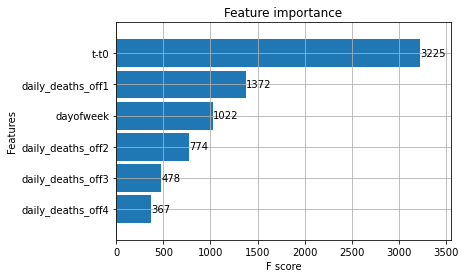

In [106]:
xgb.plot_importance(reg, height=0.9)

## Forecast on Test Data

In [107]:
def plot_performance(base_data, date_from, date_to, title=None):
    plt.figure(figsize=(15,3))
    if title == None:
        plt.title('From {0} To {1}'.format(date_from, date_to))
    else:
        plt.title(title)
    plt.xlabel('time')
    plt.ylabel('average daily deaths')
    plt.plot(base_data.index, base_data, label='data')
    plt.plot(X_test.index, X_test_pred, label='prediction')
    plt.legend()
    plt.xlim(left=date_from, right=date_to)

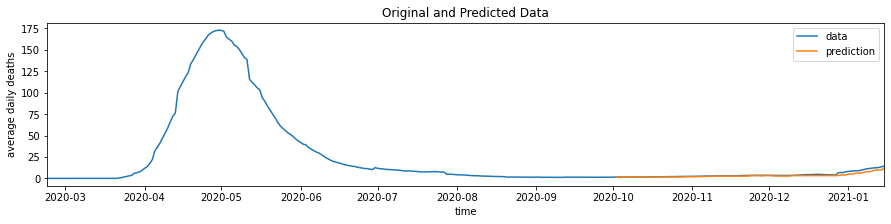

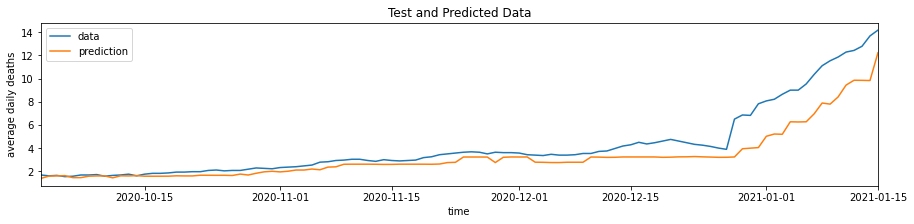

In [108]:
plot_performance(
    data["pred_deaths"], 
    data.index[0].date(), 
    data.index[-1].date(),
    'Original and Predicted Data'
)

plot_performance(
    y_test, 
    y_test.index[0].date(), 
    y_test.index[-1].date(),
    'Test and Predicted Data')

plt.legend()
plt.show()

In [109]:
# Peformance for 10 random weeks 
#random_weeks = X_test[['year', 'weekofyear']].sample(10)
#for week in random_weeks.iterrows():
#    index = (X_test.year == week[1].year) & \
#            (X_test.weekofyear == week[1].weekofyear)
#    tmp = y_test[index]
#    plot_performance(tmp, tmp.index[0].date(), tmp.index[-1].date())

## Forecast the unknown

In [110]:
def create_features2(df):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    #df['quarter'] = df['date'].dt.quarter
    #df['month'] = df['date'].dt.month
    #df['year'] = df['date'].dt.year
    #df['dayofyear'] = df['date'].dt.dayofyear
    #df['dayofmonth'] = df['date'].dt.day
    #df['weekofyear'] = df['date'].dt.weekofyear

    return df.drop(['date'], axis=1)

In [111]:
# Initialize loop
X_future = pd.DataFrame({ "date": [X_test.index.max() + timedelta(days=1)]})
# Time from 1/1/2020
X_future["origin"] = pd.to_datetime(date(2020,1,1))
X_future["t-t0"] = (X_future["date"] - X_future["origin"]).dt.days
X_future = X_future.drop(columns=['origin'])
X_future = X_future.set_index('date')
X_future = create_features2(X_future) 
X_future = X_test.tail(4).append(X_future)
y_forecast = y_test[-4:].to_list()

# Add rows from prior data
X_future.iloc[-1, X_future.columns.get_loc("daily_deaths_off1")] = y_test[-1]
X_future.iloc[-1, X_future.columns.get_loc("daily_deaths_off2")] = y_test[-2]
X_future.iloc[-1, X_future.columns.get_loc("daily_deaths_off3")] = y_test[-3]
X_future.iloc[-1, X_future.columns.get_loc("daily_deaths_off4")] = y_test[-4]

X_forecast = X_future
y_forecast.append(reg.predict(X_future)[0])

In [112]:
# Forcast the next n days
forecast_days = 100
for i in range(forecast_days):
    X_future = pd.DataFrame({ "date": [X_future.index.max() + timedelta(days=1)]  })
    
     # Time from 1/1/2020
    X_future["origin"] = pd.to_datetime(date(2020,1,1))
    X_future["t-t0"] = (X_future["date"] - X_future["origin"]).dt.days
    X_future = X_future.drop(columns=['origin'])
    
    X_future = X_future.set_index('date')
    X_future = create_features2(X_future) 
    
    # Add rows from prior forecast
    X_future['daily_deaths_off1'] = y_forecast[-1]
    X_future['daily_deaths_off2'] = y_forecast[-2]
    X_future['daily_deaths_off3'] = y_forecast[-3]
    X_future['daily_deaths_off4'] = y_forecast[-4]
    
   

    X_forecast = X_forecast.append(X_future)
    y_forecast.append(reg.predict(X_future)[0])

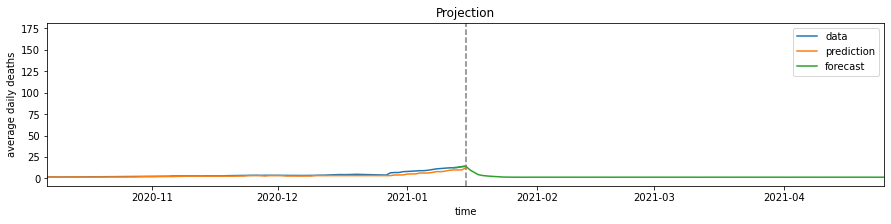

In [113]:
plot_performance(
    data["pred_deaths"], 
    data.index[-1].date() - timedelta(days=forecast_days), 
    data.index[-1].date() + timedelta(days=forecast_days),
    'Projection'
)

plt.plot(X_forecast.index, y_forecast, label='forecast')
plt.axvline(x=data.index[-1].date(), color='grey', linestyle='--')
plt.legend()
plt.show()

In [114]:
# Need to seed some earlier dates so longer projection periods do not truncate early data
# Add holidays
# Add predicting a given county using another counties rates
# Try predicting cumulative, or cumulative per 100k